In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
import torch
import pyvene as pv
import pprint
from task import MetaLearningTask, FineTuningTask
from transformers import BatchEncoding, PretrainedConfig
import jax.random as jr
from torch2jax import j2t, t2j
import dataclasses
import pyreft
import nvidia_smi
from models.mamba import MambaLMHeadModel
from dataclasses import dataclass
from mamba_ssm.utils.generation import InferenceParams
from task import DynamicIntervenableModel, TuneConfig, LoraConfig, ReftConfig
import gc
from models.gpt import GPT, GPTConfig
from models.mamba import MambaLMHeadModel, MambaConfig
from pympler import asizeof
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import lightning as L
from torch.nn import init
from peft import PeftModel
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

In [2]:
IDS = {'mamba': 'ale6kz0k', 'gpt': 'duy6u49u'}

In [ ]:
all_trans = j2t(jnp.stack([task.full_data.get_transition(i) for i in np.arange(len(task.full_data))]))

In [ ]:
ft_trans = j2t(jnp.stack([task.full_data.get_transition(i) for i in task.latent_indices]))

In [ ]:
task.full_data.get_emission(1213).sum(0)

Array([5.835e-01, 5.332e-01, 3.333e-01, 2.500e-01, 7.153e-05, 2.500e-01,
       3.333e-01, 7.153e-05, 1.000e+00, 7.153e-05, 3.999e-01, 7.153e-05,
       2.001e-01, 3.333e-01, 7.153e-05, 9.995e-01, 6.665e-01, 7.153e-05,
       7.153e-05, 2.500e-01, 7.002e-01, 5.000e-01, 7.153e-05, 2.001e-01,
       3.333e-01, 7.153e-05, 7.153e-05, 7.153e-05, 5.000e-01, 2.001e-01,
       7.153e-05, 7.153e-05, 7.153e-05, 7.002e-01, 7.153e-05, 7.500e-01,
       5.332e-01, 3.333e-01, 4.500e-01, 1.866e+00, 5.332e-01, 5.835e-01,
       1.816e+00, 4.500e-01, 2.001e-01, 2.500e-01, 5.332e-01, 2.033e+00,
       7.153e-05, 3.999e-01], dtype=float16)

In [ ]:
(ft_trans>0).sum(0)[0]

tensor([   0, 1440, 1440,    0,    0,    0,  768,  768,  768,    0,    0,    0,
           0,  768, 2304,    0,    0,    0, 2304,  768], device='cuda:0')

In [ ]:
(all_trans>0).sum(0)[0]

tensor([   0, 2880, 2880,    0,  768,    0,  768, 1536,  768,    0,  768,    0,
           0, 1536, 5088,  768,  768,    0, 2304, 1536], device='cuda:0')

In [ ]:
(task.full_data.latent_transmat.reshape((-1,20,20)) > 0).sum(0)[0]

Array([  0, 120, 120,   0,  32,   0,  32,  64,  32,   0,  32,   0,   0,
        64, 212,  32,  32,   0,  96,  64], dtype=int32)

In [ ]:
task.full_data.latent_transmat.sum((0,1,2,3,4,5,6,7)).shape

(20, 20)

In [10]:
task = FineTuningTask(
    TuneConfig(
        IDS["gpt"],
        method_config=LoraConfig(r=4, target_modules="all-linear"),
        constraints=[[1, 0], [2, 0], [4, 1], [6, 0], [7, 0]],
        precompute_pp=True,
        prefix_size=(20,30)
    )
).cuda()

number of parameters: 10.67M
Loaded dataset : (11288/1000)


Seed set to 42


Loaded checkpoing : last.ckpt
Precomputing fine-tuning oracle...


1000it [00:22, 44.93it/s]

Done


In [11]:
trainer = L.Trainer(
    max_steps=100,
    accelerator="gpu",
    enable_checkpointing=False,
    val_check_interval=50,
    reload_dataloaders_every_n_epochs=1,
    check_val_every_n_epoch=None,
)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
envs_1 = np.random.randint(0, 5000, 64).tolist()
envs_2 = np.random.randint(0, 5000, 64).tolist()

In [12]:
trainer.validate(task)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

ValueError: `self.log(val/active_kl, tensor([[   inf,    inf,    inf,  ..., 0.0394, 0.0122, 0.0168],
        [   inf,    inf,    inf,  ..., 0.1485, 0.1343, 0.0097],
        [   inf,    inf,    inf,  ..., 0.0327, 0.0135, 0.0147],
        ...,
        [   inf,    inf,    inf,  ..., 0.4945, 1.3858, 0.0162],
        [   inf,    inf,    inf,  ..., 0.0744, 1.4382, 0.0136],
        [   inf,    inf,    inf,  ..., 0.0102, 0.0101, 0.0397]]))` was called, but the tensor must have a single element. You can try doing `self.log(val/active_kl, tensor([[   inf,    inf,    inf,  ..., 0.0394, 0.0122, 0.0168],
        [   inf,    inf,    inf,  ..., 0.1485, 0.1343, 0.0097],
        [   inf,    inf,    inf,  ..., 0.0327, 0.0135, 0.0147],
        ...,
        [   inf,    inf,    inf,  ..., 0.4945, 1.3858, 0.0162],
        [   inf,    inf,    inf,  ..., 0.0744, 1.4382, 0.0136],
        [   inf,    inf,    inf,  ..., 0.0102, 0.0101, 0.0397]]).mean())`

In [ ]:
out = task.full_data.__getitems__(envs=envs_1, length=100, intv_idx=(10,20), intv_envs=envs_2)

In [ ]:
import jax

In [ ]:
a = (1,2,3)

[autoreload of task failed: Traceback (most recent call last):
  File "/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/cvmfs/ai.mila.quebec/apps/arch/distro/python/3.10/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/mila/l/leo.gagnon/latent_control/task.py", line 13, in <module>
    from data.hmm import (
ImportError: cannot import name 'SubsetIntervened' from 'data.hmm' (/home/mila/l/leo.gagnon/latent_control/data/hmm.py

In [ ]:
a[:2]

(1, 2)

In [ ]:
starts = jnp.array(np.random.random_integers(0,20, 256))

/tmp/ipykernel_3762389/942957312.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 20 + 1) instead
  starts = jnp.array(np.random.random_integers(0,20, 256))


In [ ]:
torch.Tensor([1,2,3])[2:]

tensor([3.])

In [ ]:
X,Z = jax.vmap(task.full_data.sample, (0, None, 0))(
            jnp.arange(256),
            100,
            jr.split(jr.PRNGKey(10), 256)
        )

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [ ]:
isinstance(1, tuple)

False

In [ ]:
assert np.logical_xor(True,True), 'lol'

AssertionError: lol

In [ ]:
cutoff = jnp.array(np.random.randint(0,50,256))

In [ ]:
start_states = Z[jnp.arange(256),cutoff]

In [ ]:
val_active_seqs = torch.concatenate(
    [
        task.full_data.__getitems__(batch)[0]
        for batch in torch.split(torch.IntTensor(task.val_data['active'].indices), 256)
    ],
    dim=0,
)

In [ ]:
# Compute oracle
assumed_envs = jnp.array(task.latent_indices)
oracle_pp = []
print("Precomputing validation oracle...")
for seq in tqdm(val_active_seqs):
    oracle_pp.append(task.full_data.bayesian_oracle(assumed_envs, t2j(seq)[1:]))

Precomputing validation oracle...


100%|██████████| 1000/1000 [00:07<00:00, 138.97it/s]


In [ ]:
# Compute oracle
assumed_envs = jnp.arange(len(task.full_data))
oracle_pp_full = []
print("Precomputing validation oracle...")
for seq in tqdm(val_active_seqs):
    oracle_pp_full.append(task.full_data.bayesian_oracle(assumed_envs, t2j(seq)[1:]))

Precomputing validation oracle...


100%|██████████| 1000/1000 [02:03<00:00,  8.11it/s]


In [ ]:
oracle_pp = j2t(jnp.stack(oracle_pp)).cpu()
oracle_pp_full = j2t(jnp.stack(oracle_pp_full)).cpu()

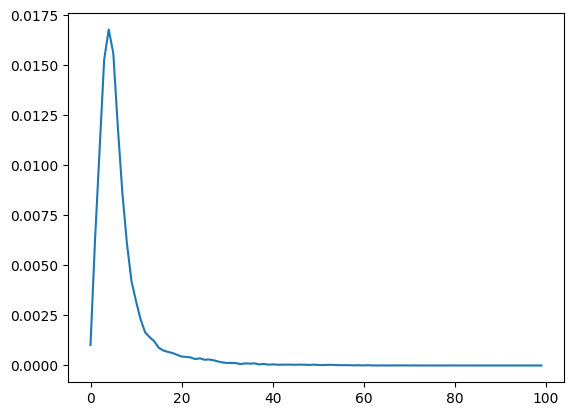

In [ ]:
plt.plot(torch.abs(oracle_pp_full - oracle_pp).mean((0,-1)))

In [ ]:
oracle_pp_full.shape

torch.Size([1000, 100, 50])

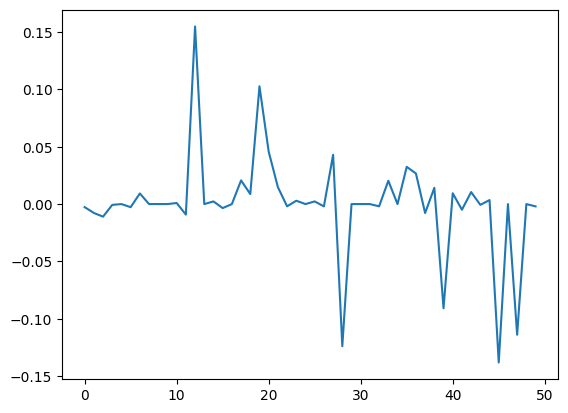

In [ ]:
i=3
plt.plot(oracle_pp[0,i] - oracle_pp_full[0,i])

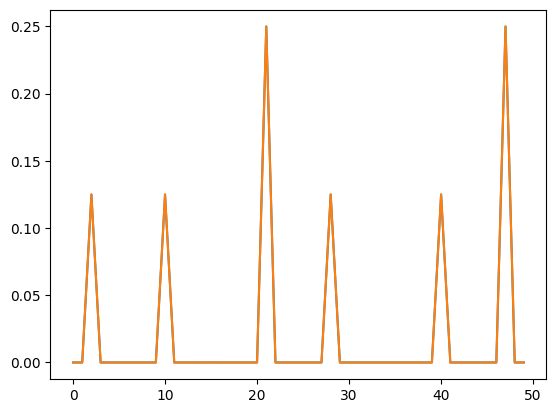

In [ ]:
plt.plot(oracle_pp[0,i])
plt.plot(oracle_pp_full[0,i])

In [ ]:
pred = torch.softmax(task.model(val_active_seqs)[...,:-1],-1).cpu().detach()

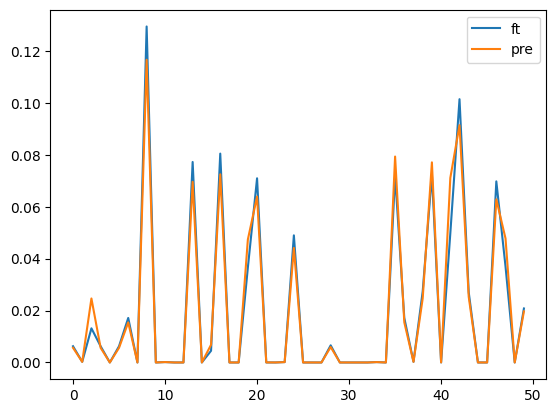

In [ ]:
plt.plot(oracle_pp[5,7], label='ft')
plt.plot(oracle_pp_full[5,7], label='pre')
#plt.plot(pred[4,3], label='pred')
plt.legend()

In [ ]:
task = FineTuningTask(
    TuneConfig(
        IDS['gpt'],
        [[1, 0]],
        method_config=ReftConfig(
            reft_cls='consreft', low_rank_dimension=64, layers=[2,3,4,5], t_slice=(-1,None,-1), component="output"
        ),
        batch_size=32,
        precompute_pp=True
        
    )
)
task.model.to("cuda")

number of parameters: 10.44M
Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt
Precomputing fine-tuning oracle...


 23%|██▎       | 226/1000 [00:25<01:26,  8.97it/s]


KeyboardInterrupt: 

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [79]:
trainer.validate(task)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

UnboundLocalError: local variable 'pad_mask' referenced before assignment

In [ ]:
inp = torch.randn((1, 384), device="cuda")

out = list(task.model.interventions.values())[0][0](
    inp
)

print(torch.sum((inp - out) ** 2))

tensor(2.5637, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
task.model.model.cuda();

seqs = task.full_data.__getitems__(torch.arange(32), length=100)[0]

out_reft = task.model(seqs)

out_normal = task.model.model(seqs)

print(((out_reft - out_normal[...,:51])**2).sum())

tensor(2736.0762, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
(out_reft.argmax(-1) == out_normal.argmax(-1)).sum(1)

tensor([98, 96, 95, 95, 97, 94, 96, 97, 96, 91, 94, 94, 94, 95, 98, 92, 94, 93,
        95, 98, 96, 96, 97, 95, 94, 94, 92, 96, 96, 92, 90, 95],
       device='cuda:0')

In [ ]:
task.model.cuda();

seqs = task.full_data.__getitems__(torch.arange(32), length=100)[0]

out_lora = task.model(seqs)

with task.model.disable_adapter():
    out_normal = task.model(seqs)

print(((out_lora - out_normal)**2).sum())

AttributeError: 'DynamicIntervenableModel' object has no attribute 'disable_adapter'

In [ ]:
out = task.model(seqs)

In [ ]:
out_reft.shape

torch.Size([32, 100, 51])

In [ ]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 34359738368
Free memory: 29704519680
Used memory: 4655218688


In [ ]:
del logits
gc.collect()
torch.cuda.empty_cache()